# Milestone 1

 Data Collection, Exploration, and Preprocessing

Objectives:
• Collect and preprocess satellite imagery data for land classification tasks.

##  1. Data Collection:

Setup & Mount Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rasterio matplotlib  scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 106.2 MB/s eta 0:00:00


In [3]:
import os
import cv2
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

using open datasets such as the EuroSat Dataset (available on GitHub) that
contains labeled satellite images for land type classification.

In [4]:
final_dataset_path = "/content/drive/My Drive/DEPI/Data/Processed_Data"
os.makedirs(final_dataset_path, exist_ok=True)

In [5]:
dataset_path = "https://zenodo.org/records/7711810/files/EuroSAT_MS.zip?download=1"
Data_path='/content/drive/My Drive/DEPI/Data/Original_Data'
import zipfile
import requests

def download_eurosat(destination=Data_path):
    os.makedirs(destination, exist_ok=True)
    url = dataset_path
    zip_path = os.path.join(destination, 'EuroSAT_RGB.zip')

    print("[INFO] Downloading EuroSAT RGB dataset...")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(zip_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

    print("[INFO] Extracting ZIP file...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(destination)

    os.remove(zip_path)
    print("[INFO] Dataset ready at:", destination)

In [6]:
download_eurosat()

[INFO] Downloading EuroSAT RGB dataset...
[INFO] Extracting ZIP file...
[INFO] Dataset ready at: /content/drive/My Drive/DEPI/Data/Original_Data


In [7]:
IMAGE_SIZE = (64, 64)

'''
    "B01 - Aerosols",
    "B02 - Blue",
    "B03 - Green",
    "B04 - Red",
    "B05 - Red edge 1",
    "B06 - Red edge 2",
    "B07 - Red edge 3",
    "B08 - NIR",
    "B08A - Red edge 4",
    "B09 - Water vapor",
    "B10 - Cirrus",
    "B11 - SWIR 1",
    "B12 - SWIR 2"
'''

BANDS = [1, 2, 3, 7]

Ensure the data includes multispectral images that capture various spectral bands (Red, Green, Blue, Near Infrared, etc.).

In [8]:
sample_image_path = None

for root, dirs, files in os.walk(Data_path):
    for file in files:
        if file.endswith(".tif"):
            sample_image_path = os.path.join(root, file)
            break
    if sample_image_path:
        break

if sample_image_path:
    with rasterio.open(sample_image_path) as src:
        num_bands = src.count
        print(f"Sample Image: {sample_image_path}")
        print(f" Number of Spectral Bands: {num_bands}")
else:
    print("No images found in the dataset!")

Sample Image: /content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/Forest/Forest_2230.tif
 Number of Spectral Bands: 13


##  2. Data Exploration:

Load & Display an Image & Load a sample image and check its properties.

In [9]:
print(os.listdir(Data_path))

['EuroSAT_MS']


In [10]:
Data_path='/content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/'

In [11]:
print(os.listdir(Data_path))

['Forest', 'River', 'Highway', 'AnnualCrop', 'SeaLake', 'HerbaceousVegetation', 'Industrial', 'Residential', 'PermanentCrop', 'Pasture']


In [12]:
land_types =['Forest', 'River', 'Highway', 'AnnualCrop', 'SeaLake', 'HerbaceousVegetation', 'Industrial', 'Residential', 'PermanentCrop', 'Pasture']

In [13]:
selected_images = {}

# Go to land type folders and pick one image
for land_type in os.listdir(Data_path):
    land_type_path = os.path.join(Data_path, land_type)
    if os.path.isdir(land_type_path):
        for filename in os.listdir(land_type_path):
            if filename.endswith(".tif"):
                selected_images[land_type] = os.path.join(land_type_path, filename)
                break

for land_type, image_path in selected_images.items():
    print(f"✅ Selected {land_type}: {image_path}")


example_land_type = list(selected_images.keys())[0]
example_image_path = selected_images[example_land_type]

with rasterio.open(example_image_path) as src:
    image = src.read()

print(f"✅ Loaded {example_land_type} image with shape: {image.shape}")


✅ Selected Forest: /content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/Forest/Forest_2230.tif
✅ Selected River: /content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/River/River_1817.tif
✅ Selected Highway: /content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/Highway/Highway_1320.tif
✅ Selected AnnualCrop: /content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/AnnualCrop/AnnualCrop_1855.tif
✅ Selected SeaLake: /content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/SeaLake/SeaLake_1126.tif
✅ Selected HerbaceousVegetation: /content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/HerbaceousVegetation/HerbaceousVegetation_921.tif
✅ Selected Industrial: /content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/Industrial/Industrial_216.tif
✅ Selected Residential: /content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/Residential/Residential_1535.tif
✅ Selected PermanentCrop: /content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS/PermanentCrop/PermanentCr

 Perform exploratory data analysis (EDA) to understand the composition of the images, including the number of bands and their relevance to land type classification.

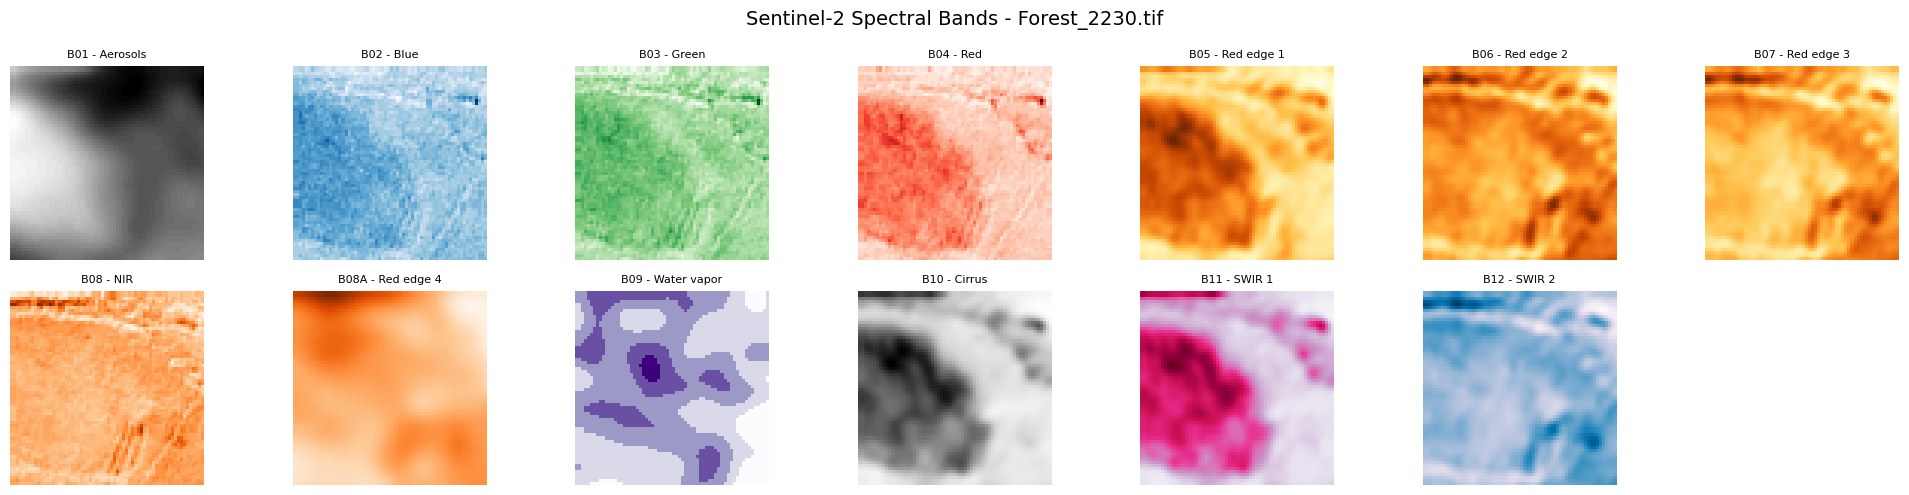

In [14]:

# Sentinel-2 band names
BAND_LABELS = [
    "B01 - Aerosols",
    "B02 - Blue",
    "B03 - Green",
    "B04 - Red",
    "B05 - Red edge 1",
    "B06 - Red edge 2",
    "B07 - Red edge 3",
    "B08 - NIR",
    "B08A - Red edge 4",
    "B09 - Water vapor",
    "B10 - Cirrus",
    "B11 - SWIR 1",
    "B12 - SWIR 2"
]

# Colormap per band based on wavelength
BAND_COLORS = [
    'gray',     # B01 - Aerosols
    'Blues',    # B02 - Blue
    'Greens',   # B03 - Green
    'Reds',     # B04 - Red
    'YlOrBr',   # B05 - Red edge 1
    'YlOrBr',   # B06 - Red edge 2
    'YlOrBr',   # B07 - Red edge 3
    'Oranges',  # B08 - NIR
    'Oranges',  # B08A - Red edge 4
    'Purples',  # B09 - Water vapor
    'Greys',    # B10 - Cirrus
    'PuRd',     # B11 - SWIR 1
    'PuBu',     # B12 - SWIR 2
]

def plot_bands(image, filename):
    num_bands = image.shape[0]
    plt.figure(figsize=(20, 5))
    for i in range(num_bands):
        plt.subplot(2, (num_bands + 1) // 2, i + 1)

        band = image[i].astype(np.float32)
        band = (band - band.min()) / (band.max() - band.min() + 1e-6)

        cmap = BAND_COLORS[i] if i < len(BAND_COLORS) else 'gray'
        label = BAND_LABELS[i] if i < len(BAND_LABELS) else f"Band {i + 1}"

        plt.imshow(band, cmap=cmap)
        plt.title(label, fontsize=8)
        plt.axis("off")

    plt.suptitle(f"Sentinel-2 Spectral Bands - {filename}", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_bands(image, os.path.basename(example_image_path))


Inspect the dataset for potential issues, such as imbalanced classes, missing data, or mislabeled images

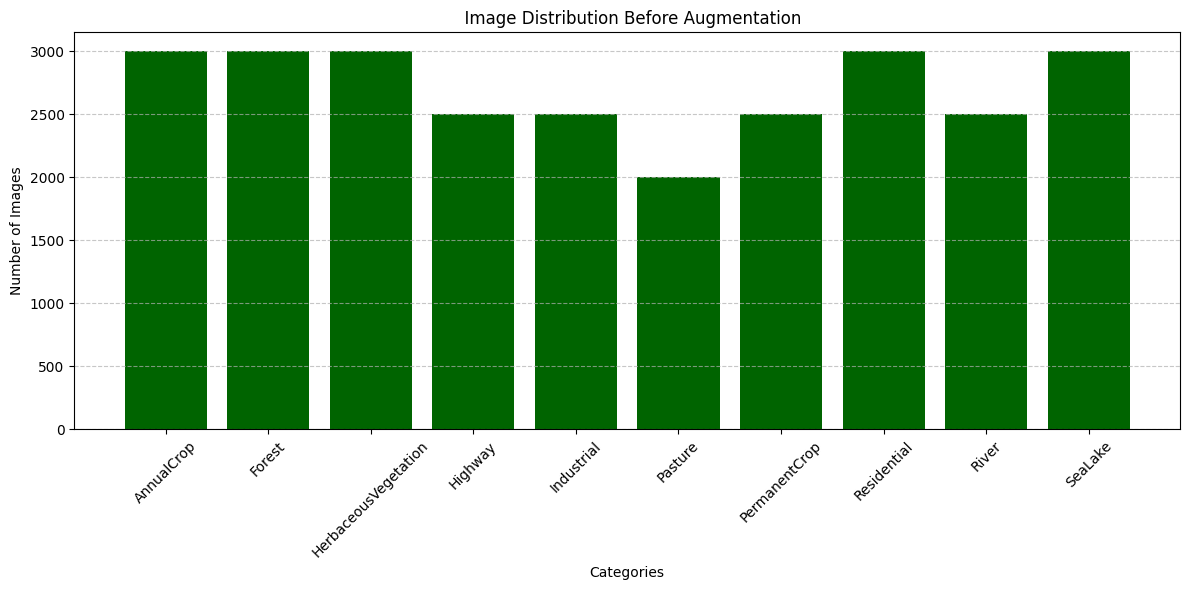

In [15]:
#  Count Images  (Before Augmentation)
categories = sorted(os.listdir(Data_path))
category_counts = {}

for category in categories:
    category_folder = os.path.join(Data_path, category)
    if os.path.isdir(category_folder):
        category_counts[category] = len([file for file in os.listdir(category_folder) if file.endswith(".tif")])


category_names = list(category_counts.keys())
image_counts = list(category_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(category_names, image_counts, color="darkgreen")
plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.title("  Image Distribution Before Augmentation")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


 Function to process a single image from TIFF


In [17]:
def process_tiff_image(image_path, bands=range(1, 13)):  # Default: All bands (B01 to B12)
    with rasterio.open(image_path) as src:
        img = src.read(list(bands)).astype(np.float32)
        img = np.transpose(img, (1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min())
    return img

def process_rgb_image(image_path, bands=[4, 3, 2]):
    with rasterio.open(image_path) as src:
        img = src.read(bands).astype(np.float32)
        img = np.transpose(img, (1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min())
    return img



Visualize sample images from different land types (e.g., agricultural land, urban, water,
desert) and examine their spectral signatures.

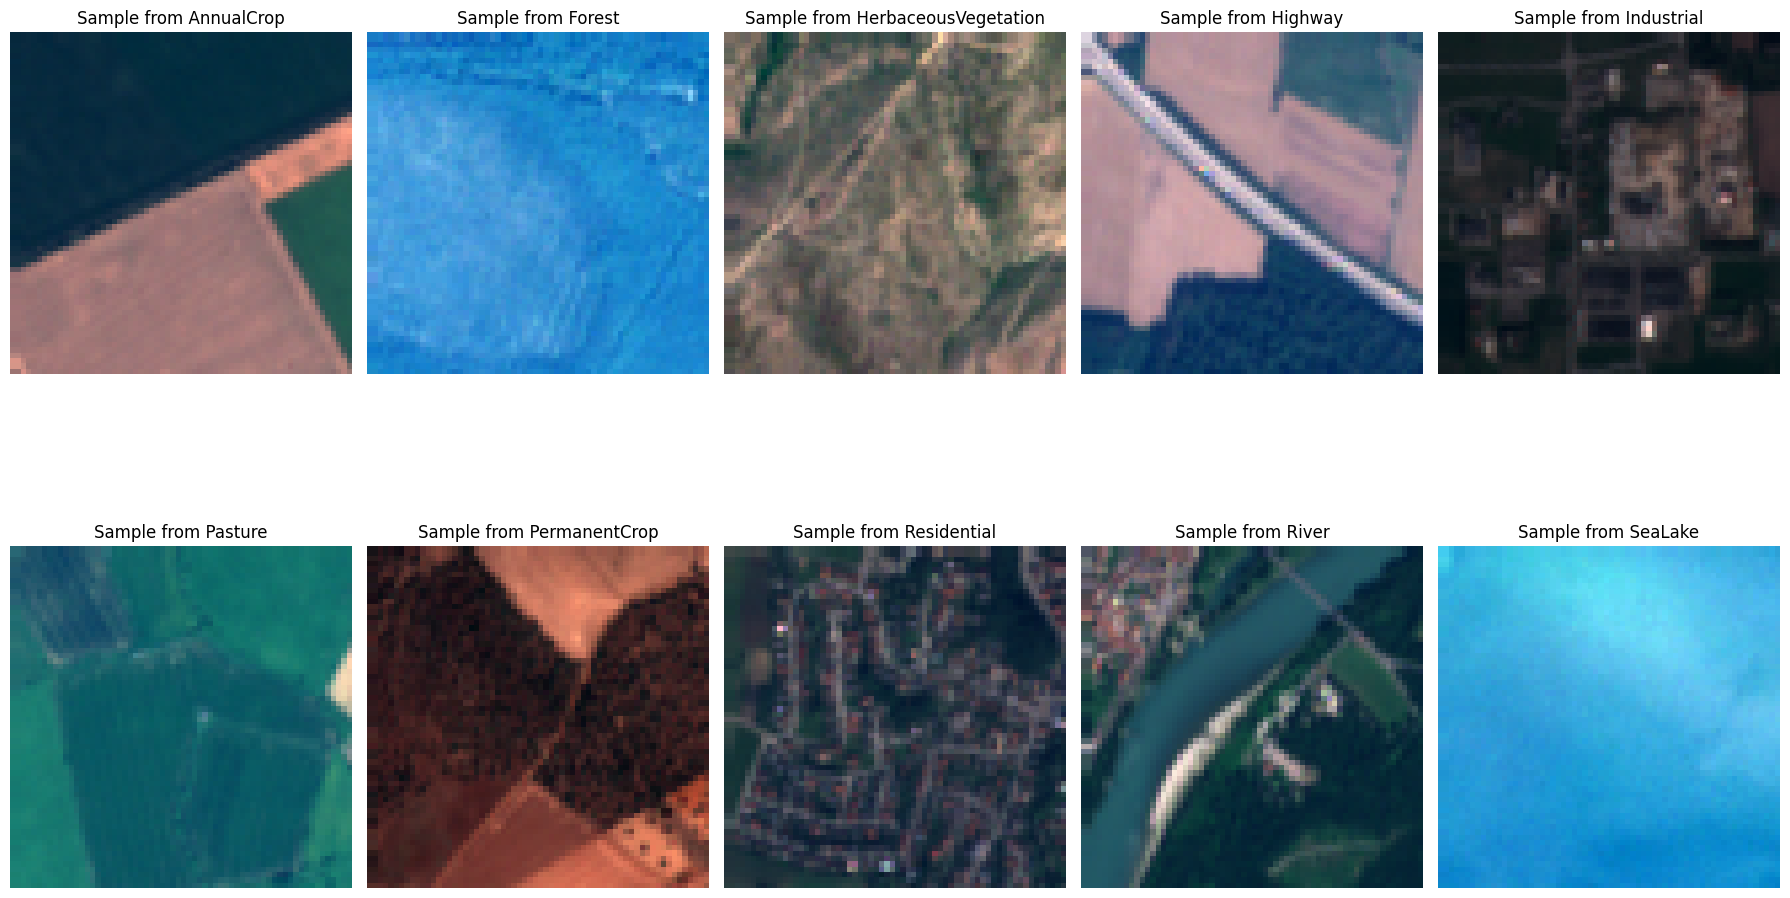

In [18]:
def visualize_sample_images(data_path):
    categories = sorted(os.listdir(Data_path))

    plt.figure(figsize=(18, 12))

    for i, category in enumerate(categories):
        category_path = os.path.join(data_path, category)
        sample_file = next(f for f in os.listdir(category_path) if f.lower().endswith(".tif"))
        sample_image_path = os.path.join(category_path, sample_file)

        img = process_rgb_image(sample_image_path)

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Sample from {category}")

    plt.tight_layout()
    plt.show()

# Usage example
visualize_sample_images(Data_path)

##  3. Preprocessing and Feature Engineering:

 Define Image Processing & Augmentation

In [19]:
import albumentations as A

augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.RandomRotate90( ),
    A.RandomBrightnessContrast(p=0.2),
])


Test the Processing & Augmentation

In [20]:
sample_path = os.path.join(Data_path, sorted(os.listdir(Data_path))[0])

sample_file = next(f for f in os.listdir(sample_path) if f.lower().endswith(".tif"))
sample_image_path = os.path.join(sample_path, sample_file)

processed_image = process_rgb_image(sample_image_path)
print(f'The Img Shape = {processed_image.shape}')

The Img Shape = (64, 64, 3)


 Apply augmentation

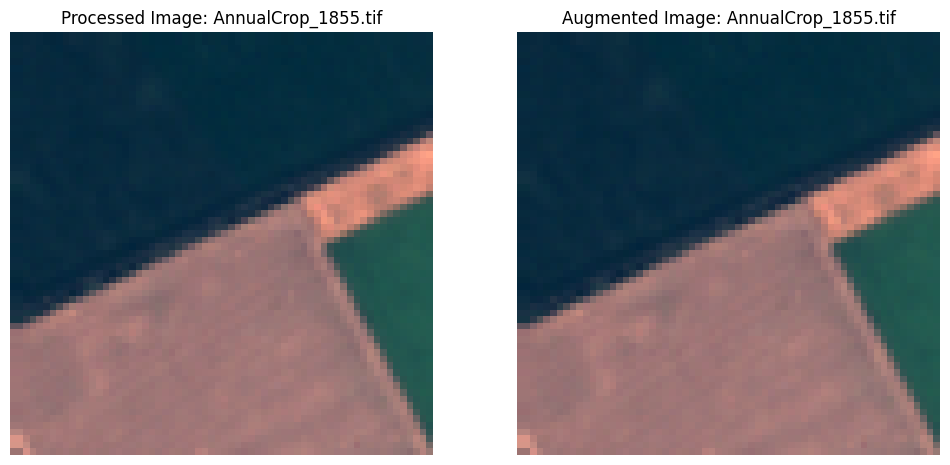

In [21]:
augmented = augmentation(image=processed_image)["image"]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(processed_image[:, :, :3])
plt.axis("off")
plt.title(f"Processed Image: {sample_file}")

plt.subplot(1, 2, 2)
plt.imshow(augmented[:, :, :3])
plt.axis("off")
plt.title(f"Augmented Image: {sample_file}")
plt.show()

**Compute NDVI for one Image**

Consider calculating additional features such as vegetation indices (e.g., NDVI – Normalized Difference Vegetation Index) for better differentiation between land types like trees and agriculture.

In [22]:
def compute_ndvi(image, nir_band=3, red_band=2):  # Computes NDVI using Near-Infrared (B8) and Red (B4) bands.
    nir = image[:, :, nir_band].astype(float)
    red = image[:, :, red_band].astype(float)
    ndvi = (nir - red) / (nir + red + 1e-5)
    return ndvi

Apply NDVI

In [23]:
sample_path = os.path.join(Data_path, sorted(os.listdir(Data_path))[0])

sample_file = next(f for f in os.listdir(sample_path) if f.lower().endswith(".tif"))
sample_image_path = os.path.join(sample_path, sample_file)

processed_image = process_tiff_image(sample_image_path)

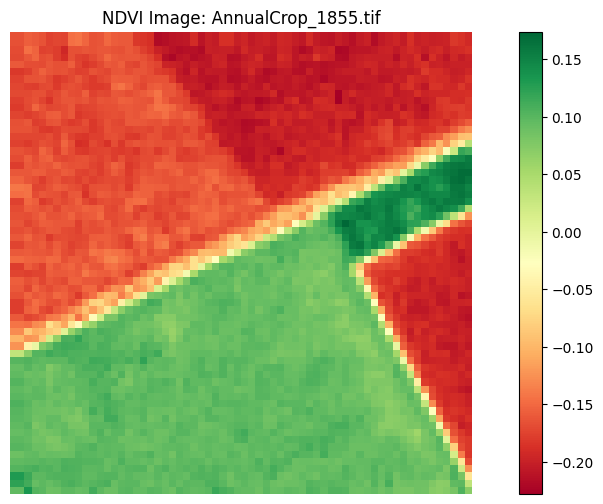

In [24]:
ndvi = compute_ndvi(image=processed_image)

plt.figure(figsize=(12, 6))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.axis("off")
plt.title(f"NDVI Image: {sample_file}")
plt.show()


##  4. Exploratory Data Analysis (EDA):

In [25]:
def visualize_land_type_and_spectrals(data_path, land_types, bands=range(1, 13)):
    plt.figure(figsize=(16, 5 * len(land_types)))

    for i, land_type in enumerate(land_types):
        path = os.path.join(data_path, land_type)
        file = next(f for f in os.listdir(path) if f.lower().endswith(".tif"))
        img = process_rgb_image(os.path.join(path, file), bands)

        rgb = (img[:, :, [3, 2, 1]] - img.min()) / (img.max() - img.min())
        spectral = img.mean(axis=(0, 1))

        plt.subplot(len(land_types), 2, 2 * i + 1)
        plt.imshow(rgb)
        plt.axis("off")
        plt.title(f"{land_type} - RGB")

        plt.subplot(len(land_types), 2, 2 * i + 2)
        plt.plot(spectral, marker='o')
        plt.xticks(range(len(bands)), [BAND_LABELS[b - 1] for b in bands], rotation=45)
        plt.title(f"{land_type} - Spectral Signature")

    plt.tight_layout()
    plt.show()


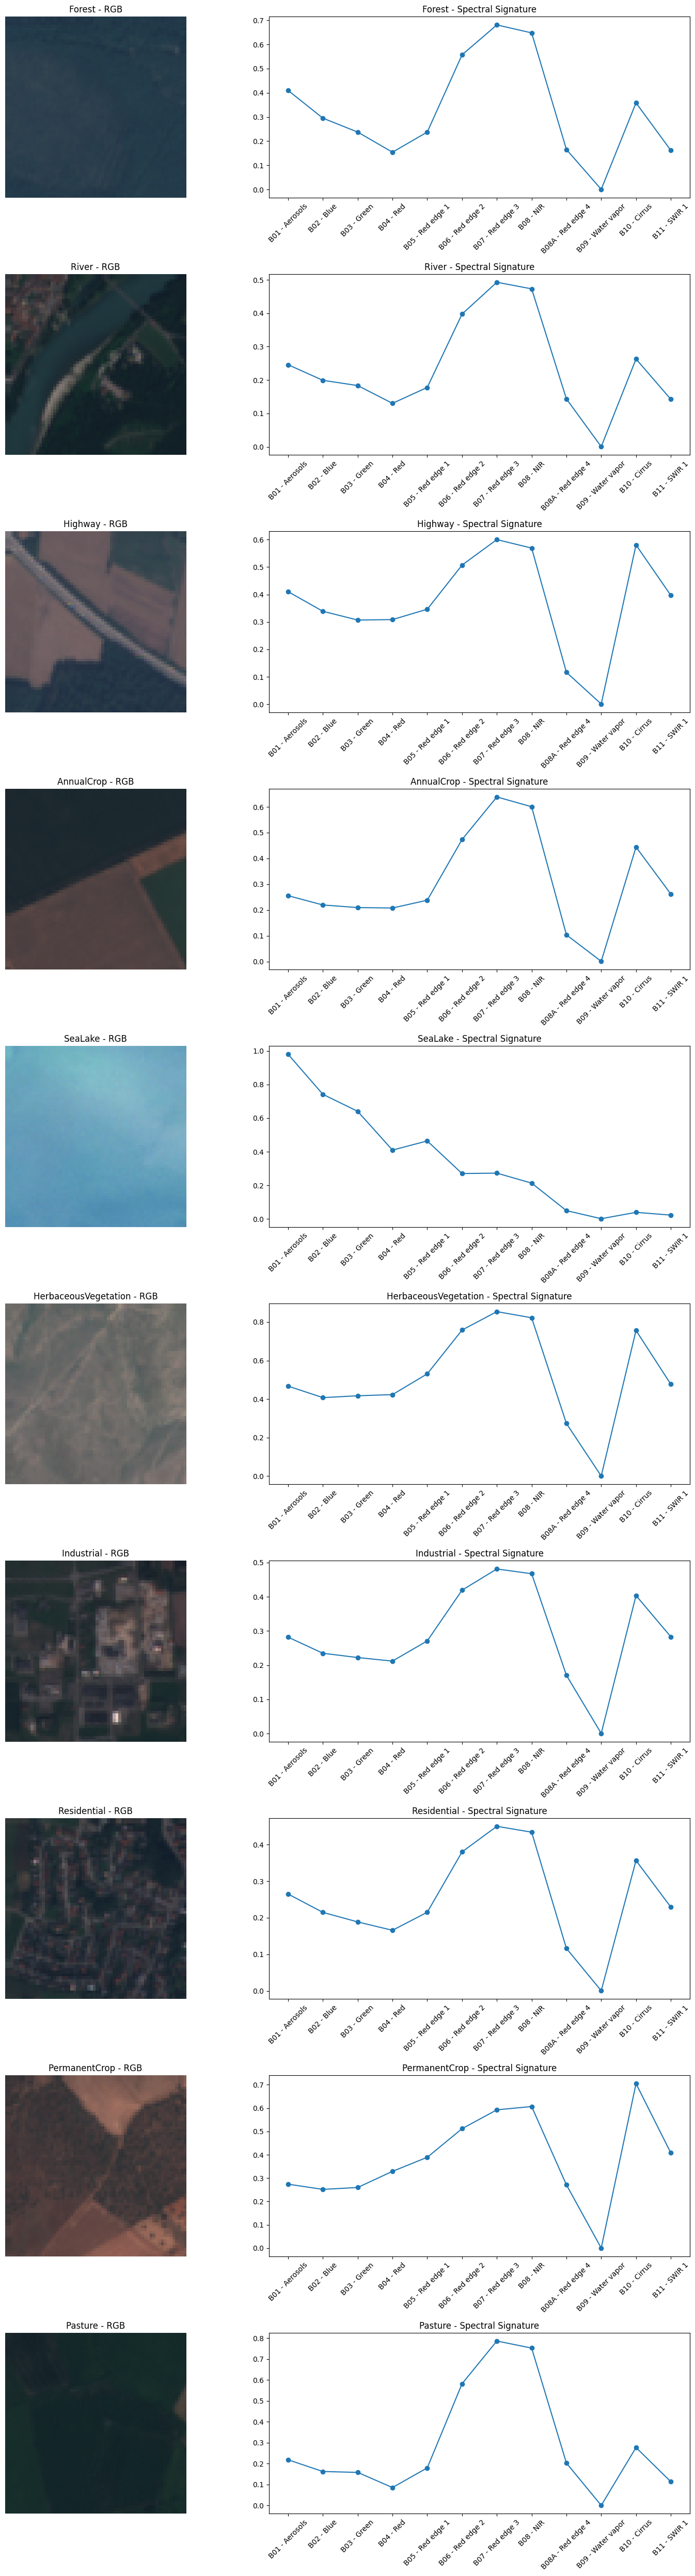

In [26]:
visualize_land_type_and_spectrals(Data_path, land_types)

## Save The processed Images

In [27]:
import shutil

def clear_folder(directory_path):
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path)
        print(f"Folder {directory_path} is cleared.")
    else:
        print(f"Folder {directory_path} does not exist.")

clear_folder(final_dataset_path)

Folder /content/drive/My Drive/DEPI/Data/Processed_Data is cleared.


In [28]:
import numpy as np
import os

def save_all_processed_images(data_path, final_dataset_path):
    types = ["RGB", "RGB_NIR", "NDVI"]


    for t in types:
        type_path = os.path.join(final_dataset_path, t)
        os.makedirs(type_path, exist_ok=True)
        print(f"Folder: {type_path} is created.")

    for category in sorted(os.listdir(data_path)):
        category_path = os.path.join(data_path, category)
        if not os.path.isdir(category_path):
            continue

        print(f"\nProcessing category: {category}")

        for file in os.listdir(category_path):
            if not file.lower().endswith(".tif"):
                continue

            file_path = os.path.join(category_path, file)
            base_name = os.path.splitext(file)[0]

            # Process images
            rgb = process_rgb_image(file_path).astype(np.float32)
            rgb_nir = process_tiff_image(file_path, bands=[4, 3, 2, 8]).astype(np.float32)
            ndvi = compute_ndvi(image=rgb_nir, nir_band=3, red_band=0).astype(np.float32)

            # Augmentation
            rgb_aug = augmentation(image=(rgb * 255).astype(np.uint8))['image']
            rgb_aug = rgb_aug.astype(np.float32) / 255.0

            # Prepare category subfolders
            for t in types:
                cat_dir = os.path.join(final_dataset_path, t, category)
                os.makedirs(cat_dir, exist_ok=True)

            # Save as .npy
            np.save(os.path.join(final_dataset_path, "RGB", category, f"{base_name}.npy"), rgb)
            np.save(os.path.join(final_dataset_path, "RGB", category, f"{base_name}_aug.npy"), rgb_aug)
            np.save(os.path.join(final_dataset_path, "RGB_NIR", category, f"{base_name}.npy"), rgb_nir)
            np.save(os.path.join(final_dataset_path, "NDVI", category, f"{base_name}.npy"), ndvi)

            print(f"Processed and saved: {file}")


In [29]:
save_all_processed_images(data_path=Data_path, final_dataset_path="/content/drive/My Drive/DEPI/Data/Processed_Data")

Streaming output truncated to the last 5000 lines.
Processed and saved: River_542.tif
Processed and saved: River_1184.tif
Processed and saved: River_556.tif
Processed and saved: River_230.tif
Processed and saved: River_1812.tif
Processed and saved: River_218.tif
Processed and saved: River_1806.tif
Processed and saved: River_1635.tif
Processed and saved: River_581.tif
Processed and saved: River_1153.tif
Processed and saved: River_595.tif
Processed and saved: River_1147.tif
Processed and saved: River_1621.tif
Processed and saved: River_2328.tif
Processed and saved: River_1609.tif
Processed and saved: River_2300.tif
Processed and saved: River_2466.tif
Processed and saved: River_2472.tif
Processed and saved: River_2314.tif
Processed and saved: River_740.tif
Processed and saved: River_998.tif
Processed and saved: River_1392.tif
Processed and saved: River_754.tif
Processed and saved: River_1386.tif
Processed and saved: River_768.tif
Processed and saved: River_1351.tif
Processed and saved: Ri

### **🚀 Conclusion**
This 1'st milestone successfully:
- ✅ Validated dataset integrity
- ✅ Checked image quality & distributions
- ✅ Confirmed the presence of **multispectral bands**
- ✅ Displayed sample images from different categories
- ✅ Preprocessed images (resize, normalize, augment)
- ✅ Computed & visualized NDVI for vegetation analysis

Next Steps:
- **Milestone 2** : Advanced Data Analysis and Model Selection

# Milestone 2

 Advanced Data Analysis and Model Selection